In [53]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,3960
1,3720
2,3930
3,3930
4,3860


In [54]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.7)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [55]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 3s 86ms/step - loss: 0.0711 - val_loss: 0.0102
Epoch 2/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 3/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0049 - val_loss: 0.0194
Epoch 4/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0040 - val_loss: 0.0147
Epoch 5/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0040 - val_loss: 0.0104
Epoch 6/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0035 - val_loss: 0.0106
Epoch 7/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0035 - val_loss: 0.0131
Epoch 8/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0035 - val_loss: 0.0118
Epoch 9/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0035 - val_loss: 0.0134
Epoch 10/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0036 - val_loss: 0.0091

In [56]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


12/12 [==============================] - 0s 6ms/step


In [57]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 23ms/step
[[14658.98 ]
 [14598.079]
 [14682.716]
 [14846.055]
 [15007.89 ]
 [15143.028]
 [15273.228]
 [15428.356]
 [15610.765]
 [15797.873]
 [15978.667]
 [16154.074]
 [16294.102]
 [16356.218]
 [16348.086]
 [16325.818]
 [16338.479]
 [16393.01 ]
 [16491.201]
 [16640.873]
 [16827.143]
 [17008.555]
 [17150.123]
 [17260.953]
 [17370.727]
 [17491.143]
 [17610.482]
 [17718.762]
 [17819.76 ]
 [17918.756]]


In [58]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 975.3875914250768
MAPE trên tập test là: 6.897386210165843 %
MSLE trên tập test là: 0.005539708308815482


In [59]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

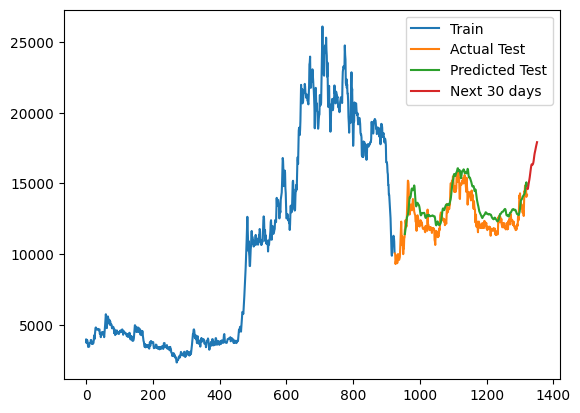

In [60]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 8/2)

In [61]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,3960
1,3720
2,3930
3,3930
4,3860


In [62]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.8)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [63]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
15/15 [==============================] - 2s 49ms/step - loss: 0.0689 - val_loss: 0.0052
Epoch 2/100
15/15 [==============================] - 1s 34ms/step - loss: 0.0081 - val_loss: 0.0051
Epoch 3/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0052 - val_loss: 0.0023
Epoch 4/100
15/15 [==============================] - 1s 34ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 5/100
15/15 [==============================] - 1s 36ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 6/100
15/15 [==============================] - 1s 34ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 7/100
15/15 [==============================] - 1s 36ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 8/100
15/15 [==============================] - 1s 33ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 9/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 10/100
15/15 [==============================] - 1s 33ms/step - loss: 0.0043 - val_loss: 0.0020

In [64]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

8/8 [==============================] - 0s 6ms/step


In [65]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 19ms/step
[[13645.574 ]
 [13639.597 ]
 [13774.88  ]
 [13902.534 ]
 [14011.845 ]
 [14141.626 ]
 [14317.784 ]
 [14547.034 ]
 [14789.306 ]
 [15007.635 ]
 [15217.865 ]
 [15403.216 ]
 [15436.939 ]
 [15275.297 ]
 [15011.415 ]
 [14742.814 ]
 [14539.328 ]
 [14409.146 ]
 [14384.293 ]
 [14475.142 ]
 [14610.006 ]
 [14769.016 ]
 [14979.945 ]
 [15219.847 ]
 [15430.94  ]
 [15572.621 ]
 [15653.286 ]
 [15698.103 ]
 [15708.5625]
 [15670.483 ]]


In [66]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 511.22116881305556
MAPE trên tập test là: 3.021291529651328 %
MSLE trên tập test là: 0.0014547578628548406


In [67]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

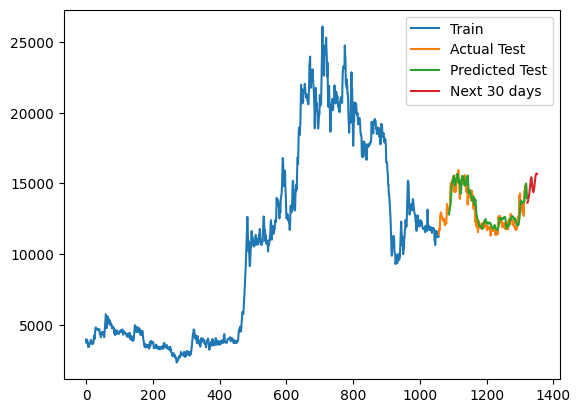

In [68]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 9/1)

In [69]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,3960
1,3720
2,3930
3,3930
4,3860


In [70]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.9)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [71]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
17/17 [==============================] - 2s 51ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 2/100
17/17 [==============================] - 1s 59ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 3/100
17/17 [==============================] - 1s 58ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 4/100
17/17 [==============================] - 1s 62ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 5/100
17/17 [==============================] - 1s 47ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 6/100
17/17 [==============================] - 1s 34ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 7/100
17/17 [==============================] - 1s 35ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 8/100
17/17 [==============================] - 1s 37ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 9/100
17/17 [==============================] - 1s 32ms/step - loss: 0.2045 - val_loss: 0.2382
Epoch 10/100
17/17 [==============================] - 1s 35ms/step - loss: 0.2045 - val_loss: 0.2382

In [72]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

4/4 [==============================] - 0s 6ms/step


In [73]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 26ms/step
[[2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]
 [2340.]]


In [74]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 10172.747383101005
MAPE trên tập test là: 81.15738379169835 %
MSLE trên tập test là: 2.796516762430768


In [75]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

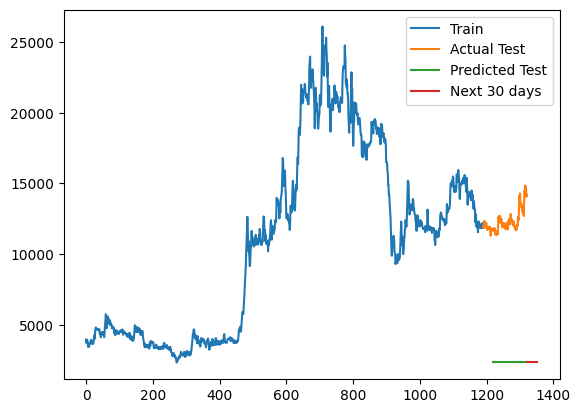

In [76]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()